# *SDSChallenge*: Preprocess groundtruth datasets


This notebook shows how to download and preprocess groundtruth shoreline data for N different sites:
- Narrabeen, Australia
- Duck, North Carolina, USA
- Torrey Pines, California, USA

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [15]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import interpolate
from scipy import stats
import pickle
import warnings

from datetime import datetime, timedelta
import pytz

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
matplotlib.use('Qt5Agg')
%matplotlib inline
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, os.path.join(os.pardir,'algorithms','COASTSAT')) 
from coastsat import SDS_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Narrabeen dataset

First, you need to download the survey data from the website. Go to the website, click `Download data`, then create a new user and select `Narrabeen Profile Data` as shown below:

![image.png](../doc/download_narrabeen.png)

A csv file called `Narrabeen_profiles.csv` will be downloaded, copy it into the `./datasets/NARRABEEN` folder. 

The cell below is used to preprocess the data into time-series of shoreline change at a user-define contour level (0.7 m for Narrabeen, which corresponds to Mean High Water Springs). 

The time-series of shoreline change are saved as `NARRABEEN_groundtruth.pkl` in the `./datasets/NARRABEEN` folder.

Extracting time-series for 5 transects using the 0.7 m contour...


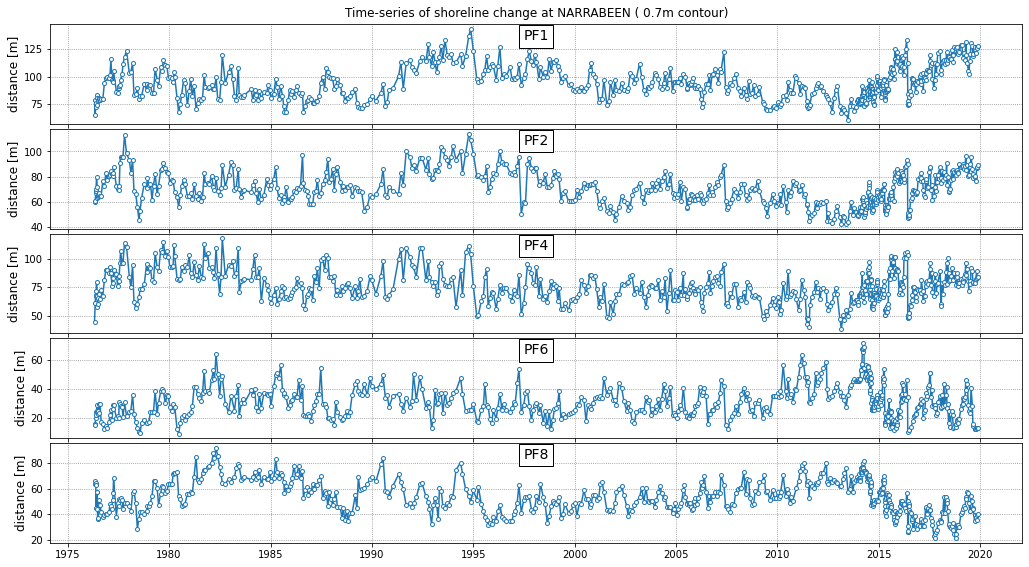

In [3]:
sitename = 'NARRABEEN'
data_folder = os.path.join(os.pardir,'datasets',sitename)
if not os.path.exists(data_folder): os.makedirs(data_folder)
    
# read the csv file
fp_dataset = os.path.join(data_folder,'Narrabeen_Profiles.csv')
df = pd.read_csv(fp_dataset)
pf_names = list(np.unique(df['Profile ID']))

# select contour level
contour_level = 0.7

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# initialise topo_profiles structure
topo_profiles = dict([])
for i in range(len(pf_names)): # for each profile
     # read dates
    df_pf = df.loc[df['Profile ID'] == pf_names[i]]
    dates_str = df['Date']
    dates_unique = np.unique(dates_str)
    # loop through dates
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    for date in dates_unique:
        # extract chainage and elevation for that date
        df_date = df_pf.loc[dates_str == date]
        chainages = np.array(df_date['Chainage'])
        elevations = np.array(df_date['Elevation'])
        if len(chainages) < 3: continue
        # sort by chainages
        idx_sorted = np.argsort(chainages)
        chainages = chainages[idx_sorted]
        elevations = elevations[idx_sorted]
        chainages_interp = np.arange(np.min(chainages)-1,np.max(chainages)+1,1)
        elevations_interp = np.interp(chainages_interp,chainages,elevations)
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations_interp, chainages_interp, bounds_error=False)
        chainage_contour_level = f(contour_level)
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        date_utc = pytz.utc.localize(datetime.strptime(date,'%Y-%m-%d'))
        topo_profiles[pf_names[i]]['dates'].append(date_utc)

# save time-series in a pickle file
with open(os.path.join(data_folder, 'NARRABEEN_groundtruth.pkl'), 'wb') as f:
    pickle.dump(topo_profiles, f)
        
# plot time-series for each transect
fig = plt.figure(figsize=[15,8], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(topo_profiles),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  


Now that we have preprocessed the in situ shoreline time-series we can use this to evaluate the accuracy of satellite-derived shorelines.

The inputs for this site are provided under `./datasets/NARRABEEN/`:
- Region of Interest (ROI): `NARRABEEN_polygon.kml`
- Transect coordinates: `NARRABEEN_transects.geojson`
- Modelled tide levels: `NARRABEEN_tides.csv`

The cell below shows how to load the input files:

Loaded polygon in epsg:4326
Loaded transects in epsg:28356
Converted polygon coordinates from 4326 to 28356
Plotted polygon and transects
Loaded tide time-series
Plotted tide time-series


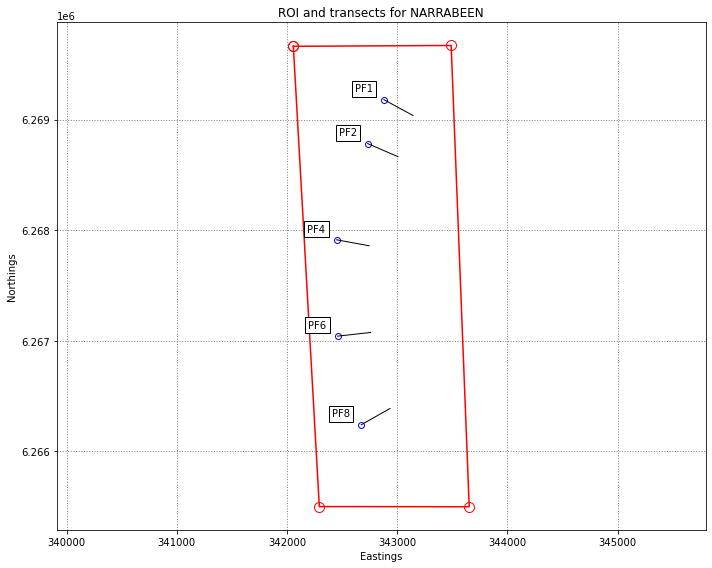

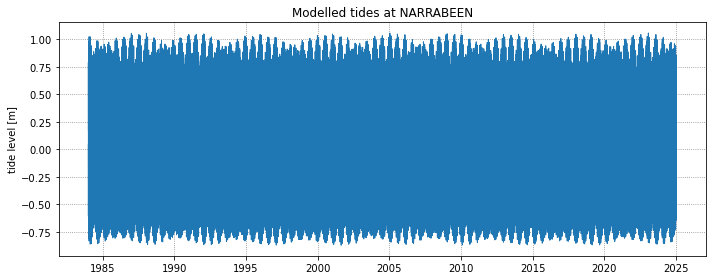

In [60]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.kml'%sitename)
polygon = SDS_tools.polygon_from_kml(fn_polygon)
print('Loaded polygon in epsg:4326')

# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)
# convert polygon to projected coordinates so they can be plotted together
polygon_proj = SDS_tools.convert_epsg(np.array(polygon[0])[:,[1,0]],4326,gdf_transects.crs.to_epsg())[:,:-1]
print('Converted polygon coordinates from 4326 to %d'%gdf_transects.crs.to_epsg())

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Eastings',ylabel='Northings',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    ax.plot(transects[key][0,0],transects[key][0,1], 'bo',mfc='None',ms=6)
    ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    ax.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
            va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
ax.plot(polygon_proj[:,0],polygon_proj[:,1],'r-o',mfc='None',ms=10)
print('Plotted polygon and transects')

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')


## Duck, North Carolina, FRF dataset

The Duck survey date is located in an CHL server so it can be downloaded programmatically.

The data is organised in .nc files, one file per survey date.

![image.png](../doc/download_duck.PNG)

The cell below downloads all the survey dates from the server:
https://chlthredds.erdc.dren.mil/thredds/catalog/frf/geomorphology/elevationTransects/survey/data/catalog.html


In [61]:
# import packages and setup ssl context
import ssl
import urllib3
from bs4 import BeautifulSoup
import wget
from netCDF4 import Dataset            
import skimage.transform as transform

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
    
# folder to save the files in
sitename = 'DUCK'
data_folder = os.path.join(os.pardir,'datasets',sitename)
if not os.path.exists(data_folder): os.makedirs(data_folder)
fp_raw = os.path.join(data_folder,'raw')
if not os.path.exists(fp_raw): os.makedirs(fp_raw)

If you don't have `wget` and/or `netCDF4` installed, you can install them on the spot with:
`pip install wget netCDF4`

Get the names of the files that will be downloaded from the catalog.html

In [25]:
# parse catalog to find all the file names
http = urllib3.PoolManager()
url_catalog = 'https://chlthredds.erdc.dren.mil/thredds/catalog/frf/geomorphology/elevationTransects/survey/data/catalog.html'
response = http.request('GET', url_catalog)
soup = BeautifulSoup(response.data)
# split string
soup_str = soup.text
soup_split = soup_str.split('.nc')
print('Found %d files to download'%len(soup_split))

Found 1133 files to download


Download the files with the survey data (takes approx. 15 minutes)

In [38]:
# download all the files
main_http_server = 'https://chlthredds.erdc.dren.mil/thredds/fileServer/frf/geomorphology/elevationTransects/survey/data/'
print('Downloading %d files...'%(len(soup_split)))
for i,text in enumerate(soup_split):
    fn = text[text.find('FRF'):]
    if i == len(soup_split) -1: continue # skip last line
    # check that date is after 1984 to speed things up
    date = fn[-8:]
    if int(date[:4]) < 1984: continue
    url = main_http_server + fn + '.nc'
    if os.path.exists(os.path.join(fp_raw,fn+'.nc')):
        continue
    # download file (try until host responds)
    file = []
    while True:
        try:
            file = wget.download(url, out=fp_raw)
            if len(file) > 0:
                break
        except:
            continue

Now we organise the data by transects. The FRF transects can be visualised on the FRF Data Porttal (https://frfdataportal.erdc.dren.mil/).

![image.png](../doc/transects_duck.PNG)

Here we pre-select the transects that have the most temporal depth in terms of surveys and extract time-series of shoreline change along those transects only.

Note that the elevation data is in NAVD88, so Mean High Water is about 0.4 m based on the local [NOAA tide gauge](https://tidesandcurrents.noaa.gov/datums.html?datum=NAVD88&units=1&epoch=0&id=8651370&name=Duck&state=NC).

The time-series of shoreline change are saved as `DUCK_groundtruth.pkl` in the `./datasets/DUCK` folder.

Extracting time-series for 2 transects using the 0.4 m contour...


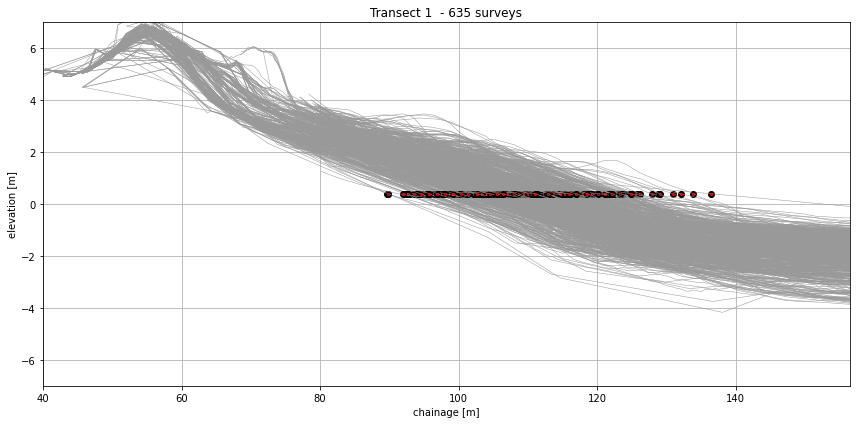

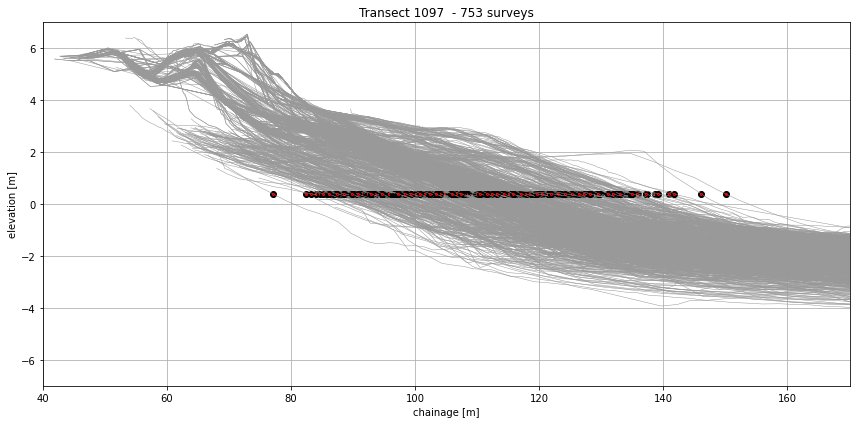

In [68]:
# format data along selected profiles (which have the most surveys)
profiles = [1, 1097,]
# [1,46, 91, 137, 183, 229, 274, 320, 366, 411, 457, 558, 594, 640, 686, 731, 
# 777, 823, 869, 914, 927, 951, 960, 1006, 1052, 1097, 1157, 1217, 1277, 1337]
pf_names = [str(_) for _ in profiles]

contour_level = 0.4 # = MHW in Navd88

print('Extracting time-series for %d transects using the %.1f m contour...'%(len(pf_names),contour_level))

# read all files and merge them
survey_data = dict([])
filenames = os.listdir(fp_raw)
filenames = [_ for _ in filenames if not _ == '.nc']
for fn in filenames:
    data = Dataset(os.path.join(fp_raw,fn))
    date_str = fn[-11:].split('.nc')[0]
    date = pytz.utc.localize(datetime.strptime(date_str,'%Y%m%d'))
    survey_number = np.array(data.variables['surveyNumber'][:])[0]
    survey_data[str(survey_number)] = dict([])
    survey_data[str(survey_number)]['date'] = date
    survey_data[str(survey_number)]['latitude'] = np.array(data.variables['lat'][:])
    survey_data[str(survey_number)]['longitude'] = np.array(data.variables['lon'][:])
    survey_data[str(survey_number)]['x'] = np.array(data.variables['xFRF'][:])
    survey_data[str(survey_number)]['y'] = np.array(data.variables['yFRF'][:])
    survey_data[str(survey_number)]['elevation'] = np.array(data.variables['elevation'][:])
    survey_data[str(survey_number)]['profile'] = np.array(data.variables['profileNumber'][:])

# format the data by profile and not by date
fp_figs = os.path.join(data_folder,'figs_profiles')
if not os.path.exists(fp_figs): os.makedirs(fp_figs)
topo_profiles = dict([])
for i in range(len(pf_names)):
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    fig, ax = plt.subplots(1,1,figsize=(12,6),tight_layout=True)
    ax.grid()
    for n in list(survey_data.keys()):
        survey = survey_data[n]
        idx = np.where(survey['profile'] == profiles[i])[0]
        if len(idx) < 3: 
            continue
        date = survey_data[n]['date']
        chainages = survey['x'][idx]
        elevations = survey['elevation'][idx]
        # sort by chainages
        idx_sorted = np.argsort(chainages)
        chainages = chainages[idx_sorted]
        elevations = elevations[idx_sorted]
        chainages_interp = np.arange(np.min(chainages)-1,np.max(chainages)+1,1)
        elevations_interp = np.interp(chainages_interp,chainages,elevations)
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations_interp, chainages_interp, bounds_error=False)
        chainage_contour_level = float(f(contour_level))
        plt.plot(chainage_contour_level,contour_level,'ko')
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        topo_profiles[pf_names[i]]['dates'].append(date)        
        ax.plot(chainages,elevations,'-',c='0.6',lw=0.5)
        ax.plot(chainage_contour_level,contour_level,'ro',ms=2,mfc='None')

    # convert to np.array
    topo_profiles[pf_names[i]]['chainages'] = np.array(topo_profiles[pf_names[i]]['chainages'])
    if len(topo_profiles[pf_names[i]]['dates']) > 0:
        ax.set(title = 'Transect %s  - %d surveys'%(pf_names[i],len(topo_profiles[pf_names[i]]['dates'])),
               xlabel='chainage [m]', ylabel='elevation [m]', ylim=[-7,7],
               xlim=[40,np.nanmax(topo_profiles[pf_names[i]]['chainages'])+20])    
        fig.savefig(os.path.join(fp_figs, 'transect_%s.jpg'%pf_names[i]), dpi=100)
    else:
        topo_profiles.pop(pf_names[i])
        plt.close(fig)
    
# save survey data
with open(os.path.join(data_folder, 'DUCK_groundtruth' + '.pkl'), 'wb') as f:
    pickle.dump(topo_profiles, f)

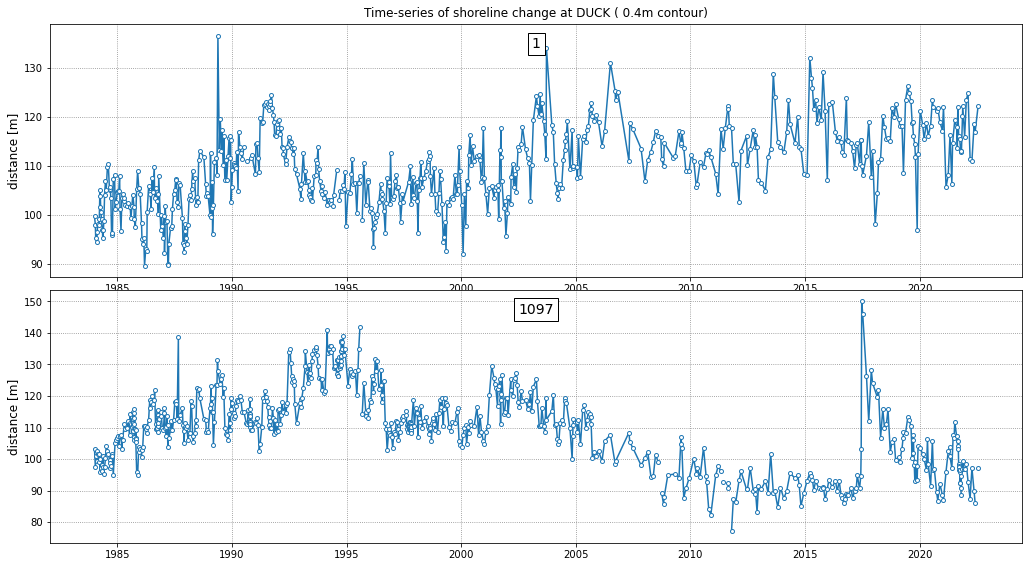

In [65]:
# plot time-series for each transect
fig = plt.figure(figsize=[15,8], tight_layout=True)
fig.suptitle('Time-series of shoreline change at %s ( %.1fm contour)'%(sitename,contour_level))
gs = gridspec.GridSpec(len(topo_profiles),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  

Loaded polygon in epsg:4326
Loaded transects in epsg:4326
Plotted polygon and transects
Loaded tide time-series
Plotted tide time-series


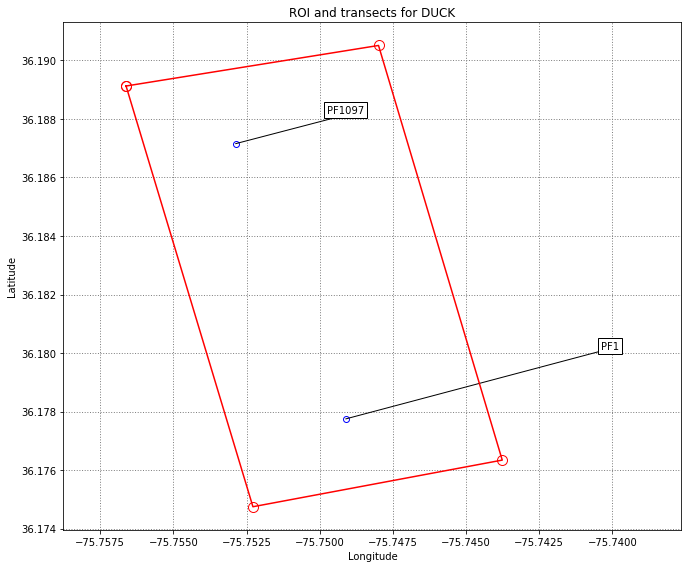

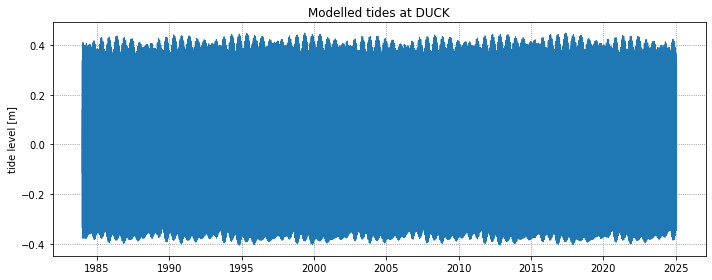

In [94]:
# read polygon ROI
fn_polygon = os.path.join(data_folder, '%s_polygon.kml'%sitename)
polygon = SDS_tools.polygon_from_kml(fn_polygon)
print('Loaded polygon in epsg:4326')

# read transects
fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
gdf_transects = gpd.read_file(fn_transects)
print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg())
# put transects into a dictionary with their name
transects = dict([])
for i in gdf_transects.index:
    transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)

# plot transects and polygon
fig,ax = plt.subplots(1,1,figsize=(10,8),tight_layout=True)
ax.grid(which='major',ls=':',c='0.5',lw=1)
ax.axis('equal')
ax.set(xlabel='Longitude',ylabel='Latitude',title='ROI and transects for %s'%sitename)
for i,key in enumerate(list(transects.keys())):
    ax.plot(transects[key][0,0],transects[key][0,1], 'bo',mfc='None',ms=6)
    ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    ax.text(transects[key][1,0], transects[key][1,1], key,
            va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))
polygon_coords = np.array(polygon[0])
ax.plot(polygon_coords[:,0],polygon_coords[:,1],'r-o',mfc='None',ms=10)
print('Plotted polygon and transects')

# load tide time-series
fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
dates_ts = [_.to_pydatetime() for _ in tide_data['dates']]
tides_ts = np.array(tide_data['tides'])
print('Loaded tide time-series')

# plot tide time-series
fig, ax = plt.subplots(1,1,figsize=(10,4), tight_layout=True)
ax.grid(which='major', linestyle=':', color='0.5')
ax.plot(tide_data['dates'], tide_data['tides'], '-',lw=1)
ax.set(ylabel='tide level [m]',title='Modelled tides at %s'%sitename)
print('Plotted tide time-series')
